# 1. 오류 유형 세분화

<span style="font-size:20px;">**사용하는 데이터 : 실제 학생들의 제출 코드(통합)**</span><br>
<span style="font-size:16px; color:green;">컬럼: 학생명/제출 시간/문제 이름/정답 여부/오류 분류/코드/대분류/prediction</span>

<span style="font-size:20px;">**컴파일 에러 유형 세분화 (약 59개의 데이터)**</span><br>
<span style="font-size:16px;">-> GPT API를 통해 기존 1가지 유형에서 4가지 유형으로 분할</span><br><br>
<span style="font-size:20px;">**WA(논리적 오류)이면서 대분류가 NOT인 경우 (약 83개의 데이터)**</span><br>
<span style="font-size:16px;">-> 오류 분류는 prediction값을 사용, 대분류는 logicalClass2.json데이터와 매핑한 값을 사용</span><br>

In [7]:
import openai
import pandas as pd
import time
import os
import json

# GPT API 설정
def question(query):
    API_KEY = "API_KEY_HERE"
    openai.api_key = API_KEY

    model = "gpt-3.5-turbo"  

    messages = [
        {"role":"system", "content":"You are a code analysis assistant. Please answer with only number(s) of the corresponding error types."},
        {"role":"user","content":query}
    ]

    response = openai.ChatCompletion.create(
        temperature=0,
        model=model,
        max_tokens=20,
        messages=messages
    )

    answer = response['choices'][0]['message']['content']
    return answer

# GPT 호출시 오류발생하면 재시도하는 함수 (retry=3번)
def question_with_retry(query, retries=3, delay=5):
    for i in range(retries):
        try:
            answer = question(query)
            return answer
        except openai.APIError:
            if i < retries - 1:
                time.sleep(delay)
            else:
                raise

# 초기 데이터
filename = "실제 학생들의 제출 코드(통합).xlsx"
df = pd.read_excel(filename)

# 오류분류 및 대분류 추가를 위한 json데이터 (문제이름-오류분류-대분류 매핑 데이터)
with open('logicalClass2.json', 'r', encoding='utf-8') as file:
    classifiers = json.load(file)

query_base = ("This code produces a compile-time error."
              "Please identify which type of compile-time error it belongs to:"
              "\n0. Syntax Errors"
              "\n1. Declaration/Definition Errors"
              "\n2. Format/Type Errors (e.g., specifier errors)"
              "\n3. Other types"
              "\n\nPlease answer with only corresponding number(s): ")

for index, row in df.iterrows():
    
    # 컴파일 에러 유형 처리
    if row["정답 여부"] == "CE":
        code = row["코드"]
        query = f"<코드>\n{code}\n\n{query_base}"  # 코드 내용을 포함한 질문
        CE_type = question_with_retry(query)
        print(f'{row["학생명"]}, {row["문제 이름"]}, 컴파일 에러 유형 : {CE_type}')
        df.at[index, "오류 분류"] = CE_type
        
    # 런타임 에러 유형 처리
    elif row["정답 여부"] == "RE":
        df.at[index, "오류 분류"] = 0 #런타임 에러의 경우 오류분류 0으로 지정
        print(f'{row["학생명"]}, {row["문제 이름"]}, 런타임 에러 유형 : 0')
        
    # 논리적에러인데 오류분류/대분류가 없는 이상치 처리
    elif row["정답 여부"] == "WA" and row["대분류"] == "NOT":
        problem_name = row["문제 이름"]
        classification = row["prediction"]
        
        # '오류 분류'에 'prediction' 값을 할당함
        df.at[index, "오류 분류"] = classification
        
        # json에서 '문제 이름'에 해당하는 딕셔너리 찾기
        if problem_name in classifiers:
            classifier_dict = classifiers[problem_name]
            
            # 문제 이름의 딕셔너리에서 '오류 분류'를 key로 하는 value를 찾아 '대분류'에 할당
            if str(classification) in classifier_dict.keys():
                df.at[index, "대분류"] = classifier_dict[str(classification)]
                print(f"{row['학생명']}, {problem_name}, 오류 분류 : {classification}, 대분류 : {df.at[index, '대분류']}")

new_filename = os.path.join(os.path.dirname(os.path.abspath(filename)), "Integrated.xlsx") # 동일 디렉토리에 Integrated.xlsx로 저장
df.to_excel(new_filename, index=False)


유제연, 10보다작을까?-1, 오류 분류 : 1, 대분류 : 1
김동우 derek0602, 10보다작을까?-2, 컴파일 에러 유형 : 0
송지훈, 10보다작을까?-2, 오류 분류 : 0, 대분류 : 1
유제연, 10보다작을까?-2, 오류 분류 : 3, 대분류 : 0
허지아 jia1014, 10보다작을까?-2, 컴파일 에러 유형 : 0
허지아 jia1014, 10보다작을까?-2, 컴파일 에러 유형 : 0
박유빈 yoobinsik, 내나이가어때서, 컴파일 에러 유형 : 2
박유빈 yoobinsik, 내나이가어때서, 컴파일 에러 유형 : 2
박유빈 yoobinsik, 내나이가어때서, 컴파일 에러 유형 : 2
박유빈 yoobinsik, 내나이가어때서, 컴파일 에러 유형 : 2
유재학 yujaehak16, 내나이가어때서, 컴파일 에러 유형 : 0
이진아, 내나이가어때서, 오류 분류 : 1, 대분류 : 2
정진욱 HARRY, 내나이가어때서, 컴파일 에러 유형 : 0
최도윤, 내나이가어때서, 오류 분류 : 3, 대분류 : 2
신승명 himond1126, 두수비교하기(<=), 런타임 에러 유형 : 0
유재학 yujaehak16, 두수비교하기(<=), 컴파일 에러 유형 : 0
유재학 yujaehak16, 두수비교하기(<=), 오류 분류 : 1, 대분류 : 0
강수인, 두수비교하기(<=), 오류 분류 : 1, 대분류 : 0
오승찬, 두수비교하기(<=), 오류 분류 : 1, 대분류 : 0
오승찬, 두수비교하기(<=), 오류 분류 : 1, 대분류 : 0
홍동인, 두수비교하기(<=), 오류 분류 : 1, 대분류 : 0
홍동인, 두수비교하기(<=), 오류 분류 : 1, 대분류 : 0
김강범 kkb110513, 두수비교하기(==), 오류 분류 : 1, 대분류 : 1
박유빈 yoobinsik, 두수비교하기(==), 컴파일 에러 유형 : 0
박유빈 yoobinsik, 두수비교하기(==), 컴파일 에러 유형 : 0
박유빈 yoobinsik, 두수비교하기(==), 컴파일 에러 유형 : 0
박유

# 2. df1(전체데이터), df2(오류데이터), df3(대분류데이터) 생성

<span style="font-size:20px;">**사용할 데이터 : Integrated.xlsx (컴파일/런타임 에러 유형이 추가된 데이터)**</span><br>
<span style="font-size:16px; color:green;">컬럼: 학생명/제출 시간/문제 이름/정답 여부/오류 분류/코드/대분류/prediction</span>

In [128]:
import pandas as pd
import datetime
import re
import numpy as np

filename = "Integrated.xlsx"
df = pd.read_excel(filename)

df

,학생명,제출 시간,문제 이름,정답 여부,오류 분류,코드,대분류,prediction
0,강지민 jiminkang1404,22.11.01 22:08,10보다작을까?-1,AC,NaN,#include <cstdio>\nint main(){\n int a;\n ...,NOT,1
1,권현욱,21.12.26 10:24,10보다작을까?-1,AC,NaN,#include<stdio.h>\nint main()\n{\nint a;\nscan...,NOT,1
2,김강범 kkb110513,22.07.30 18:11,10보다작을까?-1,AC,NaN,#include <cstdio>\n\nint main()\n{\n int a;...,NOT,1
3,김동우 derek0602,22.11.05 10:41,10보다작을까?-1,AC,NaN,#include<cstdio>\nint main(){\n int a;\n ...,NOT,1
4,김민하,21.12.18 11:24,10보다작을까?-1,AC,NaN,"#include<cstdio>\nint main(){\nint a;\nscanf(""...",NOT,1
...,...,...,...,...,...,...,...,...
1404,허윤구,21.03.07 11:15,사칙연산,AC,NaN,"#include <cstdio>\nint main()\n{\n int a, b...",NOT,2
1405,허윤구,21.03.07 11:11,사칙연산,WA,2,"#include <cstdio>\nint main(){\n int a, b;\...",0,2
1406,허윤구,21.03.07 11:10,사칙연산,WA,4,"#include <cstdio>\nint main()\n{\n int a, b...",0,4
1407,허윤구,21.03.07 11:07,사칙연산,WA,"0,2","#include<cstdio>\nint main()\n{\n int a, b;...","0,0",0


In [129]:
# 학생명에서 한국어가 아닌 모든 글자를 제거
df['학생명'] = df['학생명'].apply(lambda x: ''.join(re.findall(r'[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]', x)))

# 제출 시간을 datetime 형식으로 수정
df['제출 시간'] = df['제출 시간'].apply(lambda x: datetime.datetime.strptime(x, '%y.%m.%d %H:%M'))

# 문제 이름에서 띄어쓰기 제거하고 영어 소문자로 변경
df['문제 이름'] = df['문제 이름'].apply(lambda x: x.replace(' ', '').lower())


In [130]:
# 전처리한 데이터 확인 (학생명/제출시간/문제이름 수정완료)
df

,학생명,제출 시간,문제 이름,정답 여부,오류 분류,코드,대분류,prediction
0,강지민,2022-11-01 22:08:00,10보다작을까?-1,AC,NaN,#include <cstdio>\nint main(){\n int a;\n ...,NOT,1
1,권현욱,2021-12-26 10:24:00,10보다작을까?-1,AC,NaN,#include<stdio.h>\nint main()\n{\nint a;\nscan...,NOT,1
2,김강범,2022-07-30 18:11:00,10보다작을까?-1,AC,NaN,#include <cstdio>\n\nint main()\n{\n int a;...,NOT,1
3,김동우,2022-11-05 10:41:00,10보다작을까?-1,AC,NaN,#include<cstdio>\nint main(){\n int a;\n ...,NOT,1
4,김민하,2021-12-18 11:24:00,10보다작을까?-1,AC,NaN,"#include<cstdio>\nint main(){\nint a;\nscanf(""...",NOT,1
...,...,...,...,...,...,...,...,...
1404,허윤구,2021-03-07 11:15:00,사칙연산,AC,NaN,"#include <cstdio>\nint main()\n{\n int a, b...",NOT,2
1405,허윤구,2021-03-07 11:11:00,사칙연산,WA,2,"#include <cstdio>\nint main(){\n int a, b;\...",0,2
1406,허윤구,2021-03-07 11:10:00,사칙연산,WA,4,"#include <cstdio>\nint main()\n{\n int a, b...",0,4
1407,허윤구,2021-03-07 11:07:00,사칙연산,WA,"0,2","#include<cstdio>\nint main()\n{\n int a, b;...","0,0",0


In [131]:
# '대분류'에서 라벨을 추출하고 원핫 인코딩 수행
df['대분류_list'] = df['대분류'].apply(lambda x: x.split(','))
unique_labels = df['대분류_list'].explode().drop_duplicates().tolist()
encoded_data = df['대분류_list'].apply(lambda labels: [1 if str(label) in labels else 0 for label in unique_labels])
encoded_df = pd.DataFrame(encoded_data.to_list(), columns=unique_labels)

# 컬럼 이름 지정
col_mapping = {'0': "WA_IO", '1': "WA_CS", '2': "WA_PU", 'NOT': "WA_NOT"}
encoded_df.columns = [col_mapping[col] for col in encoded_df.columns]
df = df.join(encoded_df)
df = df.drop(columns=["대분류", "대분류_list", "WA_NOT"])

In [132]:
# 전처리한 데이터 확인 -> WA_IO, WA_CS, WA_PU 컬럼 추가:
# WA_IO 컬럼: 논리적오류 - IO에러(입출력 에러), 
# WA_CS 컬럼: 논리적오류 - CS에러(조건식 에러),
# WA_PU 컬럼: 논리적오류 - PU에러(문제 이해가 잘못됨)
df.head()

,학생명,제출 시간,문제 이름,정답 여부,오류 분류,코드,prediction,WA_CS,WA_IO,WA_PU
0,강지민,2022-11-01 22:08:00,10보다작을까?-1,AC,NaN,#include <cstdio>\nint main(){\n int a;\n ...,1,0,0,0
1,권현욱,2021-12-26 10:24:00,10보다작을까?-1,AC,NaN,#include<stdio.h>\nint main()\n{\nint a;\nscan...,1,0,0,0
2,김강범,2022-07-30 18:11:00,10보다작을까?-1,AC,NaN,#include <cstdio>\n\nint main()\n{\n int a;...,1,0,0,0
3,김동우,2022-11-05 10:41:00,10보다작을까?-1,AC,NaN,#include<cstdio>\nint main(){\n int a;\n ...,1,0,0,0
4,김민하,2021-12-18 11:24:00,10보다작을까?-1,AC,NaN,"#include<cstdio>\nint main(){\nint a;\nscanf(""...",1,0,0,0


In [133]:
# "정답 여부"에서 라벨을 추출하고 원핫 인코딩 수행
result_oh = pd.get_dummies(df["정답 여부"], prefix="", prefix_sep="")
result_oh = result_oh.drop(columns=["WA"])
final_df = pd.concat([df, result_oh], axis=1)
final_df = final_df.drop(columns=["정답 여부"])

In [134]:
# 전처리한 데이터 확인 -> AC, CE, RE 컬럼 추가
final_df.head()

,학생명,제출 시간,문제 이름,오류 분류,코드,prediction,WA_CS,WA_IO,WA_PU,AC,CE,RE
0,강지민,2022-11-01 22:08:00,10보다작을까?-1,NaN,#include <cstdio>\nint main(){\n int a;\n ...,1,0,0,0,1,0,0
1,권현욱,2021-12-26 10:24:00,10보다작을까?-1,NaN,#include<stdio.h>\nint main()\n{\nint a;\nscan...,1,0,0,0,1,0,0
2,김강범,2022-07-30 18:11:00,10보다작을까?-1,NaN,#include <cstdio>\n\nint main()\n{\n int a;...,1,0,0,0,1,0,0
3,김동우,2022-11-05 10:41:00,10보다작을까?-1,NaN,#include<cstdio>\nint main(){\n int a;\n ...,1,0,0,0,1,0,0
4,김민하,2021-12-18 11:24:00,10보다작을까?-1,NaN,"#include<cstdio>\nint main(){\nint a;\nscanf(""...",1,0,0,0,1,0,0


In [135]:
# "오류 분류" 값중 이상치가 있는지 확인
unique_error_categories = final_df['오류 분류'].unique()
print("오류 분류값의 종류:", unique_error_categories)

오류 분류값의 종류: [nan '2' 1 '1' '3' '0,1' '0' 0 3 '4' 2 4 '2,3' '0, 3' '1, 2' '5' 5 '0,3'
 '4,6' '0,2' '2, 4' '0, 2' '2 ,4' '2,4' '3, 4' '3,4' '0, 1']


In [136]:
# "오류 분류"가 Multivalue를 가지면 (ex: 0,1,2) 분할시킴
final_df['오류 분류'] = final_df['오류 분류'].apply(lambda x: [np.nan] if pd.isnull(x) else list(map(int, str(x).split(','))))
final_df = final_df.explode('오류 분류')

# "오류 분류" 컬럼을 정수형 데이터 타입으로 변경
final_df['오류 분류'] = final_df['오류 분류'].astype(pd.Int64Dtype())

In [137]:
#  전처리된 "오류 분류" 컬럼 내용 확인
unique_error_categories = final_df['오류 분류'].unique()
print("오류 분류값의 종류:", unique_error_categories)

오류 분류값의 종류: <IntegerArray>
[<NA>, 2, 1, 3, 0, 4, 5, 6]
Length: 8, dtype: Int64


In [138]:
# 전처리한 데이터 확인 (텍스트 데이터 였던 "오류 분류"값을 정수형 데이터로 변경)
final_df.head()

,학생명,제출 시간,문제 이름,오류 분류,코드,prediction,WA_CS,WA_IO,WA_PU,AC,CE,RE
0,강지민,2022-11-01 22:08:00,10보다작을까?-1,<NA>,#include <cstdio>\nint main(){\n int a;\n ...,1,0,0,0,1,0,0
1,권현욱,2021-12-26 10:24:00,10보다작을까?-1,<NA>,#include<stdio.h>\nint main()\n{\nint a;\nscan...,1,0,0,0,1,0,0
2,김강범,2022-07-30 18:11:00,10보다작을까?-1,<NA>,#include <cstdio>\n\nint main()\n{\n int a;...,1,0,0,0,1,0,0
3,김동우,2022-11-05 10:41:00,10보다작을까?-1,<NA>,#include<cstdio>\nint main(){\n int a;\n ...,1,0,0,0,1,0,0
4,김민하,2021-12-18 11:24:00,10보다작을까?-1,<NA>,"#include<cstdio>\nint main(){\nint a;\nscanf(""...",1,0,0,0,1,0,0


In [139]:
# prediction 컬럼은 더이상 필요하지 않으므로 제거
df1 = final_df.drop(columns=["prediction"])

<span style="font-size:20px;">**- df1: 입출력/조건문/문제이해/컴파일/런타임 에러로 구분된 전체 데이터**</span>

In [140]:
# 전처리 마친 데이터 df1 확인
column_order = ['학생명','제출 시간','문제 이름','코드','AC','오류 분류','WA_IO','WA_CS','WA_PU','CE','RE']
df1 = df1[column_order]
df1

,학생명,제출 시간,문제 이름,코드,AC,오류 분류,WA_IO,WA_CS,WA_PU,CE,RE
0,강지민,2022-11-01 22:08:00,10보다작을까?-1,#include <cstdio>\nint main(){\n int a;\n ...,1,<NA>,0,0,0,0,0
1,권현욱,2021-12-26 10:24:00,10보다작을까?-1,#include<stdio.h>\nint main()\n{\nint a;\nscan...,1,<NA>,0,0,0,0,0
2,김강범,2022-07-30 18:11:00,10보다작을까?-1,#include <cstdio>\n\nint main()\n{\n int a;...,1,<NA>,0,0,0,0,0
3,김동우,2022-11-05 10:41:00,10보다작을까?-1,#include<cstdio>\nint main(){\n int a;\n ...,1,<NA>,0,0,0,0,0
4,김민하,2021-12-18 11:24:00,10보다작을까?-1,"#include<cstdio>\nint main(){\nint a;\nscanf(""...",1,<NA>,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1405,허윤구,2021-03-07 11:11:00,사칙연산,"#include <cstdio>\nint main(){\n int a, b;\...",0,2,1,0,0,0,0
1406,허윤구,2021-03-07 11:10:00,사칙연산,"#include <cstdio>\nint main()\n{\n int a, b...",0,4,1,0,0,0,0
1407,허윤구,2021-03-07 11:07:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",0,0,1,0,0,0,0
1407,허윤구,2021-03-07 11:07:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",0,2,1,0,0,0,0


<span style="font-size:20px;">**- df2: 정답은 없고, 오류만 존재하는 데이터**</span>

In [150]:
df2 = df1[df1['AC'] != 1]
df2 = df2.drop(columns='AC')
df2

,학생명,제출 시간,문제 이름,코드,오류 분류,WA_IO,WA_CS,WA_PU,CE,RE
19,유재학,2022-08-07 18:16:00,10보다작을까?-1,#include <cstdio>\nint main()\n{\n int a;\n...,2,0,1,0,0,0
20,유재학,2022-08-07 18:16:00,10보다작을까?-1,#include <cstdio>\nint main()\n{\n int a;\n...,2,0,1,0,0,0
22,유제연,2022-02-12 19:45:00,10보다작을까?-1,#include<cstdio>\nint main()\n{\nint a;\nif(10...,1,0,1,0,0,0
26,이연준,2020-11-01 18:28:00,10보다작을까?-1,#include <cstdio>\n\nint main()\n{\nint a;\nsc...,1,0,1,0,0,0
32,전현준,2022-03-11 17:21:00,10보다작을까?-1,#include <cstdio>\n\nint main()\n{\nint a=11;\...,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1403,허윤구,2021-03-07 11:06:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",2,1,0,0,0,0
1405,허윤구,2021-03-07 11:11:00,사칙연산,"#include <cstdio>\nint main(){\n int a, b;\...",2,1,0,0,0,0
1406,허윤구,2021-03-07 11:10:00,사칙연산,"#include <cstdio>\nint main()\n{\n int a, b...",4,1,0,0,0,0
1407,허윤구,2021-03-07 11:07:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",0,1,0,0,0,0


<span style="font-size:20px;">**- df3: 각 학생별로 대분류 오류 (WA,CE,PU) 총합만 집계되어있는 데이터**</span>

In [142]:
df3 = df2
df3.drop(columns=['제출 시간', '문제 이름', '코드', '오류 분류'], inplace=True)
df3 = df3.groupby('학생명').sum().reset_index()
df3

,학생명,WA_IO,WA_CS,WA_PU,CE,RE
0,강석준,20,0,7,0,0
1,강수인,7,0,0,0,0
2,강지민,3,0,1,2,0
3,권현욱,4,0,2,0,0
4,김가영,13,0,0,0,0
5,김강범,10,1,4,0,0
6,김근태,4,0,0,0,0
7,김동우,15,0,6,4,0
8,김무영,23,4,3,0,0
9,김무진,50,22,12,0,0


# 3. 클러스터링 분석

<span style="font-size:20px;">**- 전체학생 데이터를 PCA 축소후 DBSCAN**</span>

C:\Users\pc\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


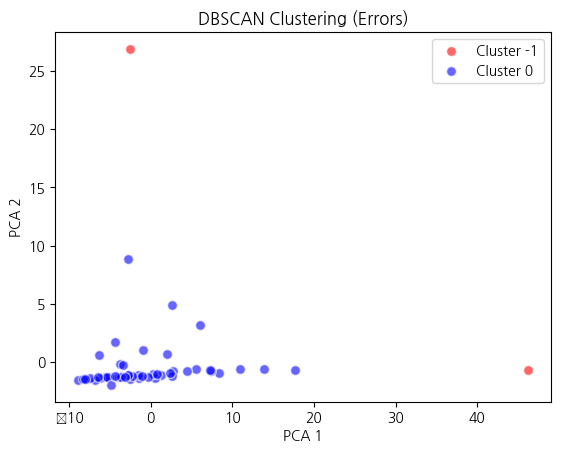

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

dbs1 = df3 # 데이터는 df3를 이용

# 클러스터링에 사용할 컬럼
selected_columns = ['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']
cluster_data = dbs1[selected_columns]

# PCA로 차원 축소
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cluster_data)

# DBSCAN 클러스터링
dbscan = DBSCAN(eps=8, min_samples=5)
dbscan.fit(reduced_data)

dbs1['cluster_labels'] = dbscan.labels_
unique_cluster_labels = sorted(list(set(dbs1['cluster_labels'])))
colors = ['red','blue','green']

# DBSCAN 결과 시각화
fig, ax = plt.subplots()
for label, color in zip(unique_cluster_labels, colors):
    sample_data = reduced_data[dbs1['cluster_labels'] == label]
    ax.scatter(sample_data[:, 0], sample_data[:, 1], c=[color], s=50, alpha=0.6, edgecolors='w', label=f"Cluster {label}")

plt.title("DBSCAN Clustering (Errors)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


<span style="font-size:20px;">**- 아웃라이어 제거**</span>

In [144]:
# 아웃라이어 제거
filtered_data = dbs1[dbs1['cluster_labels'] != -1]

<span style="font-size:20px;">**- 아웃라이어가 제거된 데이터를 이용해 K-Means 수행**</span>

<span style="font-size:16px;">**1. Elbow Method로 적절한 k값 찾기**</span>

C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable 

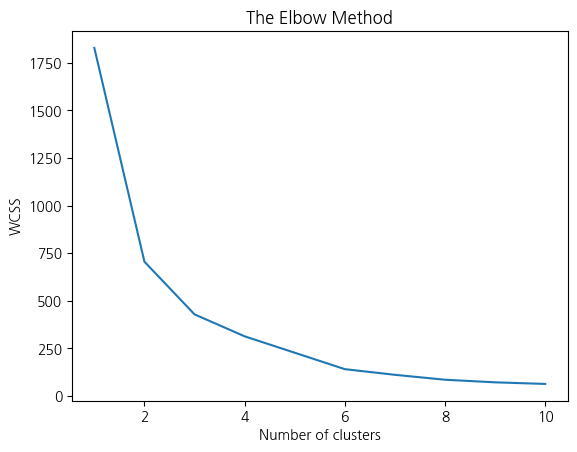

In [145]:
from sklearn.cluster import KMeans

# PCA로 차원 축소
filtered_cluster_data = filtered_data[selected_columns]
reduced_filtered_data = pca.transform(filtered_cluster_data)

# Elbow Point찾기
def plot_elbow(data, max_cluster=10):
    wcss = []  # Within-Cluster Sum of Squares를 저장할 리스트
    for i in range(1, max_cluster + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_cluster + 1), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

plot_elbow(reduced_filtered_data, max_cluster=10)


<span style="font-size:16px;">**2. Silhouette Score로 적절한 k값 찾기**</span>

C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable 

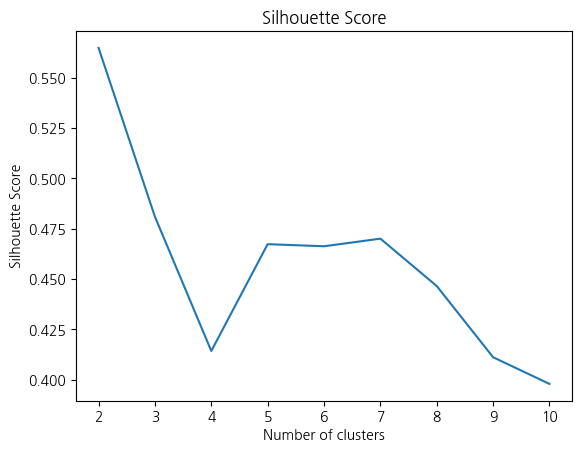

In [146]:
from sklearn.metrics import silhouette_score

# 실루엣 스코어 측정
def plot_silhouette_score(data, max_cluster=10):
    silhouette_scores = []

    for i in range(2, max_cluster + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        silhouette = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette)

    plt.plot(range(2, max_cluster + 1), silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

plot_silhouette_score(reduced_filtered_data, max_cluster=10)


<span style="font-size:20px;">**- K=2로 설정후 K-Means 클러스터링**</span>

C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\AppData\Local\Temp\ipykernel_11800\2681176165.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cluster_labels_filtered'] = kmeans_filtered.labels_
C:\Users\pc\anaconda3\lib\site-packages\IPython\core\pylabtoo

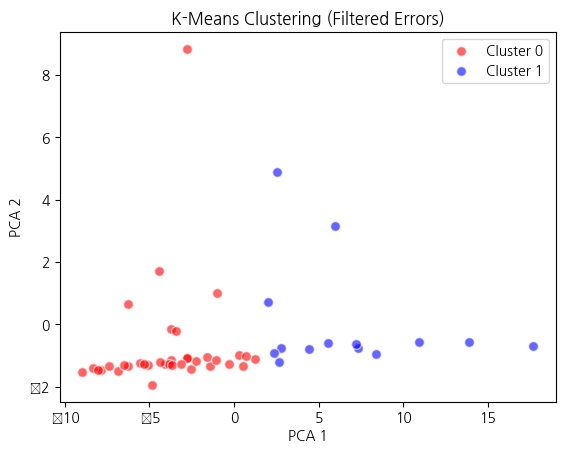

In [147]:
# K=2로 설정하고 K-Means 클러스터링
n_clusters = 2 
kmeans_filtered = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_filtered.fit(reduced_filtered_data)

filtered_data['cluster_labels_filtered'] = kmeans_filtered.labels_
unique_cluster_labels_filtered = sorted(list(set(filtered_data['cluster_labels_filtered'])))
colors = ['red','blue','green']

# 클러스터링 결과 시각화
fig_filtered, ax_filtered = plt.subplots()
for label, color in zip(unique_cluster_labels_filtered, colors):
    sample_data_filtered = reduced_filtered_data[filtered_data['cluster_labels_filtered'] == label]
    ax_filtered.scatter(sample_data_filtered[:, 0], sample_data_filtered[:, 1], c=[color], s=50, alpha=0.6, edgecolors='w', label=f"Cluster {label}")

plt.title("K-Means Clustering (Filtered Errors)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


<span style="font-size:20px;">**- 각 클러스터의 오류 유형별 비율 확인**</span>

전체중 Cluster0의 데이터 포인트 비율: 69.23%


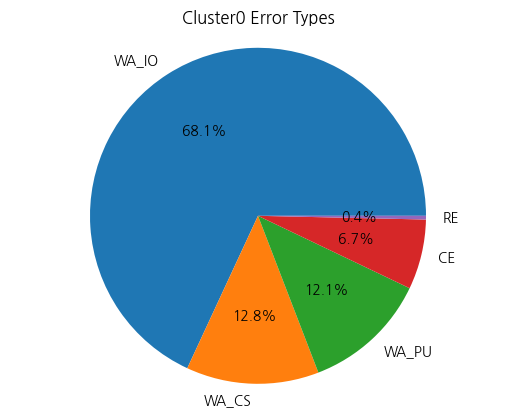


컬럼별 총합
WA_IO    192
WA_CS     36
WA_PU     34
CE        19
RE         1
dtype: int64


전체중 Cluster1의 데이터 포인트 비율: 26.92%


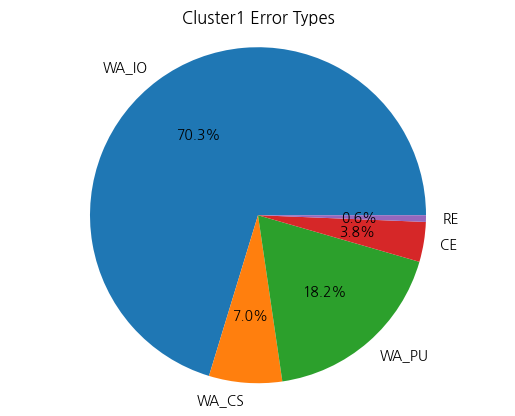


컬럼별 총합
WA_IO    220
WA_CS     22
WA_PU     57
CE        12
RE         2
dtype: int64




In [148]:
from IPython.display import display

total_count = len(dbs1)

for i in unique_cluster_labels_filtered:
    
    cluster = filtered_data[filtered_data['cluster_labels_filtered'] == i]

    # 전체 데이터 포인트중 각 Cluster에 속하는 데이터 포인트 비율을 계산후 출력
    cluster_count = len(cluster)
    cluster_percentage = (cluster_count / total_count) * 100
    print(f"전체중 Cluster{i}의 데이터 포인트 비율: {cluster_percentage:.2f}%")

    # 각 Cluster 데이터들의 오류 유형별 비율 확인
    selected_column_sums = cluster[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].sum()
    plt.pie(selected_column_sums, labels=selected_column_sums.index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(f'Cluster{i} Error Types')
    plt.show()
    print("\n컬럼별 총합")
    print(selected_column_sums)

    print("\n")

# 4. 최근 20, 15, 10, 5개 데이터에서의 오류 유형별 비율 확인

In [151]:
from IPython.display import display
data1=df2

#에러가 나는경우 df2셀을 다시 실행시켜주세요

# "제출 시간" 순으로 정렬
total_trend_data = data1.sort_values(by="제출 시간")
display(total_trend_data)


,학생명,제출 시간,문제 이름,코드,오류 분류,WA_IO,WA_CS,WA_PU,CE,RE
580,송지원,2020-05-16 12:29:00,두정수입력받기,"#include <cstdio>\n\nint main(){\nint a,b;\nsc...",1,1,0,0,0,0
798,송지원,2020-05-27 23:48:00,원의넓이구하기,#include <cstdio>\nint main(){\nint r;\nscanf(...,0,1,0,0,0,0
599,이연준,2020-10-25 17:29:00,두정수입력받기,#include <cstdio>\n\nint main()\n{\nint a;\nsc...,5,1,0,0,0,0
600,이연준,2020-10-25 17:29:00,두정수입력받기,#include <cstdio>\n\nint main()\n{\nint a;\nsc...,5,1,0,0,0,0
471,이연준,2020-10-25 17:38:00,두정수바꾸어출력하기,"#include <cstdio>\n\nint main()\n{\nint a=1, b...",0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1130,한재우,2022-12-04 12:09:00,"초를분,초단위로변환하기","#include <cstdio>\n\nint main()\n{\n int a,...",0,0,0,0,1,0
783,박유빈,2022-12-16 22:10:00,원의넓이구하기,#include<cstdio>\n\nint main()\n{\n int r;\...,0,0,0,0,1,0
784,박유빈,2022-12-16 22:10:00,원의넓이구하기,#include<cstdio>\n\nint main()\n{\n int r;\...,0,1,0,0,0,0
785,박유빈,2022-12-16 22:11:00,원의넓이구하기,#include <cstdio>\n\nint main()\n{\n int r;...,0,1,0,0,0,0


<span style="font-size:20px;">**- 전체 학생들의 최근 20, 15, 10, 5개의 오류 유형별 비율**</span>

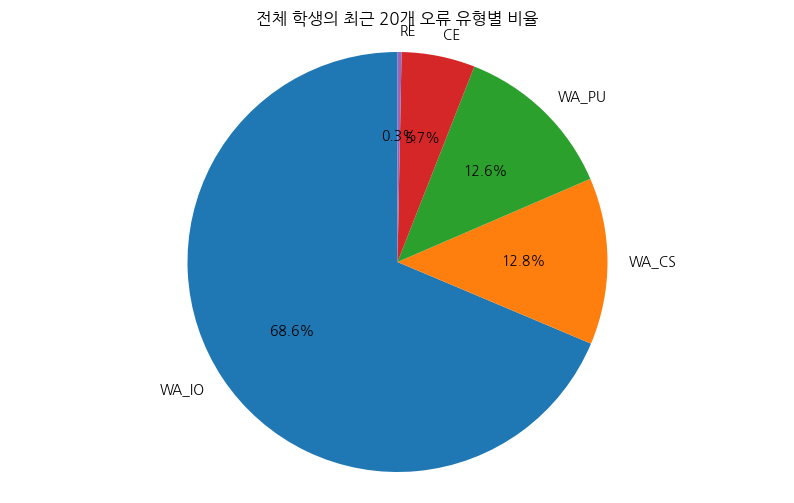

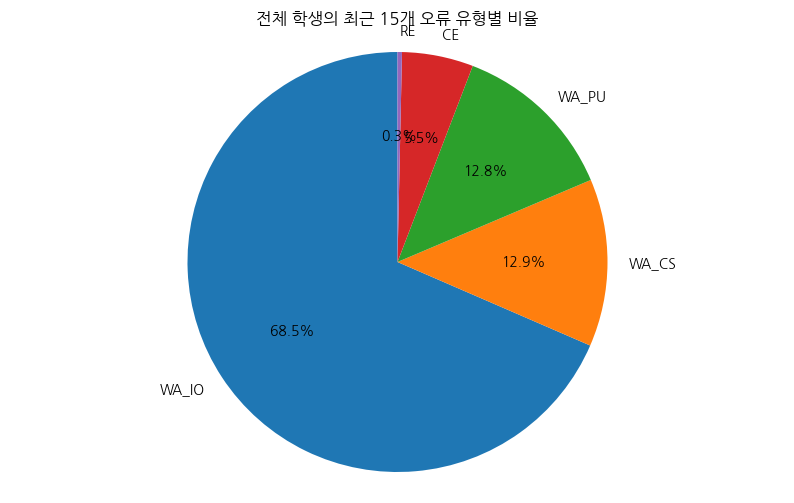

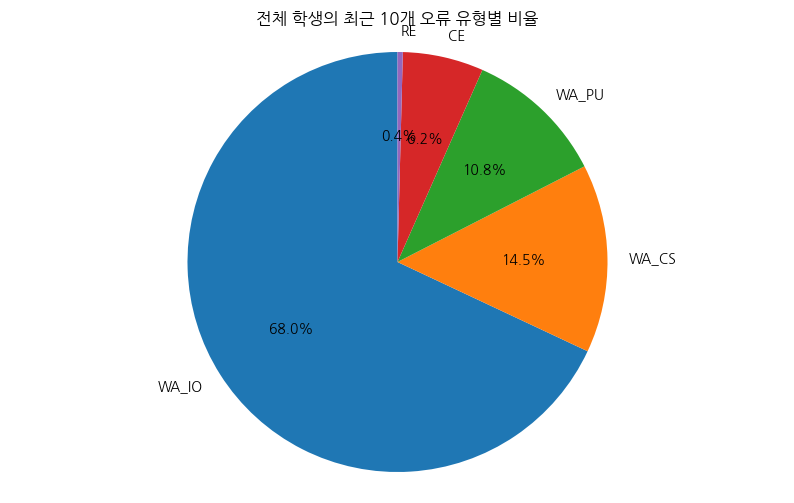

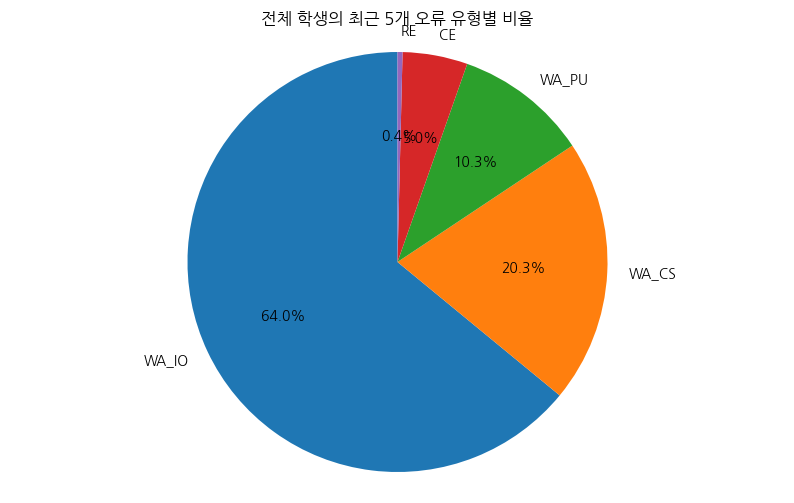

In [152]:
students = data1["학생명"].unique()
pie_slice_list = [20, 15, 10, 5]

# 원형 그래프를 그리는 함수
def draw_pie(slices, avg_ratios, title):
    plt.rcParams["font.family"] = "NanumGothic"
    plt.figure(figsize=(10, 6))
    plt.pie(avg_ratios, labels=avg_ratios.index, autopct='%.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.show()
    print()

# 원형 그래프를 그림
for num_slices in pie_slice_list:
    results = []
       
    for student in students:
        # 각 학생의 데이터를 찾고 "제출 시간" 순으로 정렬
        student_data = data1[data1["학생명"] == student].sort_values(by="제출 시간", ascending=False)

        # 최근 n개의 에러를 선택
        recent_errors = student_data[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].head(num_slices) 
        
        # 각 에러의 합을 계산하고 저장
        error_sum = recent_errors.sum()
        error_ratios = error_sum / error_sum.sum()
        error_ratios = error_ratios.fillna(0)  # NaN 값 처리
        results.append({"학생명": student, "평균 비율": error_ratios})

    # 전체 평균 비율을 계산
    average_ratios = pd.concat([result["평균 비율"] for result in results], axis=1).mean(axis=1)

    # 원형 그래프로 시각화
    draw_pie(num_slices, average_ratios, f"전체 학생의 최근 {num_slices}개 오류 유형별 비율")


# 5. 제출 시간을 통한 시간축 중심의 분석

In [153]:
#클러스터0과 클러스터1에 해당하는 학생들을 각각 그룹화
cluster0_students = filtered_data.loc[filtered_data['cluster_labels_filtered'] == 0, '학생명'].tolist()
cluster1_students = filtered_data.loc[filtered_data['cluster_labels_filtered'] == 1, '학생명'].tolist()

print("Cluster 0 students:", cluster0_students) #상대적으로 기초실력이 있는 학생 그룹
print("Cluster 1 students:", cluster1_students) #상대적으로 기초실력이 부족한 학생 그룹

Cluster 0 students: ['강수인', '강지민', '권현욱', '김강범', '김근태', '김민하', '김승희', '김정찬', '박민호', '박윤선', '박정빈', '박종원', '박준', '백리브가', '변재욱', '송지원', '송지훈', '신승명', '신예린', '신윤성', '신준우', '신희석', '오승찬', '유상원', '이예소', '이진아', '전현준', '정승환', '정시원', '조예일', '최도윤', '최수웅', '한재우', '허지아', '홍동인', '홍지형']
Cluster 1 students: ['강석준', '김가영', '김동우', '김무영', '박재윤', '서정웅', '신제민', '유재학', '유제연', '이석우', '이연준', '임선균', '정진욱', '허윤구']


In [154]:
import seaborn as sns

data4=df2 #데이터는 df2를 사용. 에러발생시 df2셀을 다시 실행시켜주세요

# 학생명과 제출 시간을 기준으로 데이터를 정렬
data4 = data4.sort_values(['학생명', '제출 시간'])

# 제출시간을 기준으로 각 학생마다 오래된것부터 0,1,2...로 "제출 시간"값을 변경 
data4['제출 시간'] = data4.groupby('학생명').cumcount()

data4

,학생명,제출 시간,문제 이름,코드,오류 분류,WA_IO,WA_CS,WA_PU,CE,RE
626,강석준,0,두정수입력받기,"#include<cstdio>\n\nint main()\n{\n int a,b...",0,1,0,0,0,0
626,강석준,1,두정수입력받기,"#include<cstdio>\n\nint main()\n{\n int a,b...",3,1,0,0,0,0
627,강석준,2,두정수입력받기,"#include<cstdio>\n\nint main()\n{\n int a, ...",0,1,0,0,0,0
627,강석준,3,두정수입력받기,"#include<cstdio>\n\nint main()\n{\n int a, ...",3,1,0,0,0,0
1051,강석준,4,정수한개입력받아부호바꿔출력하기,#include <cstdio>\n\nint main()\n{\n int a;...,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
506,홍지형,3,두정수바꾸어출력하기,"#include <cstdio>\nint main()\n{\n int a,b;...",0,1,0,0,0,0
1337,홍지형,4,사칙연산,"#include <cstdio>\n\nint main()\n{\n int a,...",0,1,0,0,0,0
1337,홍지형,5,사칙연산,"#include <cstdio>\n\nint main()\n{\n int a,...",2,1,0,0,0,0
1338,홍지형,6,사칙연산,"#include <cstdio>\n\nint main()\n{\n int a,...",3,1,0,0,0,0


<span style="font-size:20px;">**- 전체학생의 제출 시간별 오류 분석**</span>

C:\Users\pc\AppData\Local\Temp\ipykernel_11800\802637445.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_time = data4.groupby('제출 시간').sum().reset_index()


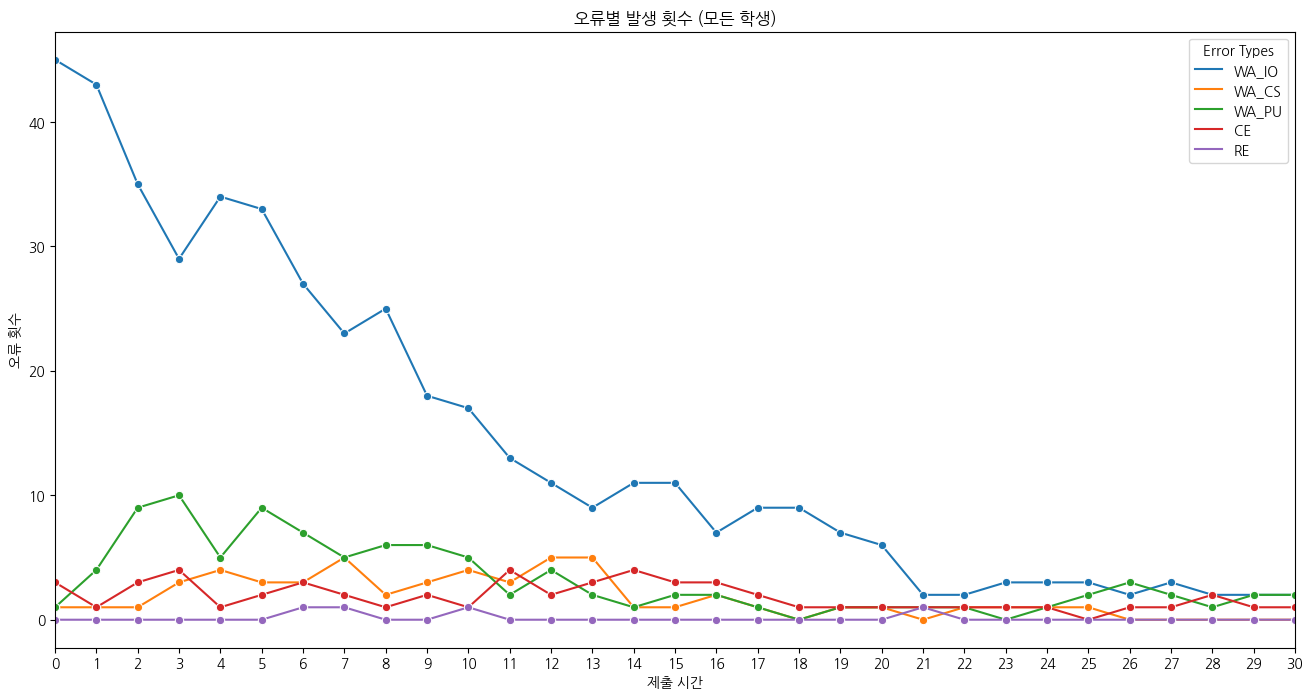

In [155]:
# 오류 유형별 합계 계산후 데이터프레임 구성
error_by_time = data4.groupby('제출 시간').sum().reset_index()
error_count = error_by_time.melt(id_vars='제출 시간',
                                              value_vars=['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE'],
                                              var_name='Error Types',
                                              value_name='count')

# 시각화
plt.rcParams["font.family"] = "NanumGothic"
plt.figure(figsize=(16, 8))
sns.lineplot(data=error_count, x='제출 시간', y='count', hue='Error Types', marker='o')

plt.title("오류별 발생 횟수 (모든 학생)")
plt.xlabel("제출 시간")
plt.ylabel("오류 횟수")

plt.xlim(0, 30) # 최소 학생수>3
plt.xticks(range(0, 31))
plt.show()

<span style="font-size:20px;">**- 전체학생의 제출 시간별 오류 분석 (y축: 해당 제출시간의 오류 유형별 비율)**</span><br>
이전의 그래프는 단순 누적만을 보여주기 때문에 제출 시간이 뒤로갈수록 샘플수가 적어져 자연스럽게 오류 횟수도 감소함<br>이 문제점을 보완하기 위해 y축을 (오류횟수 / 해당 제출시간에 제출한 학생수)로 하여 평균화된 수치로 고정함.

C:\Users\pc\AppData\Local\Temp\ipykernel_11800\4004379055.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_time = data4.groupby('제출 시간').sum().reset_index()


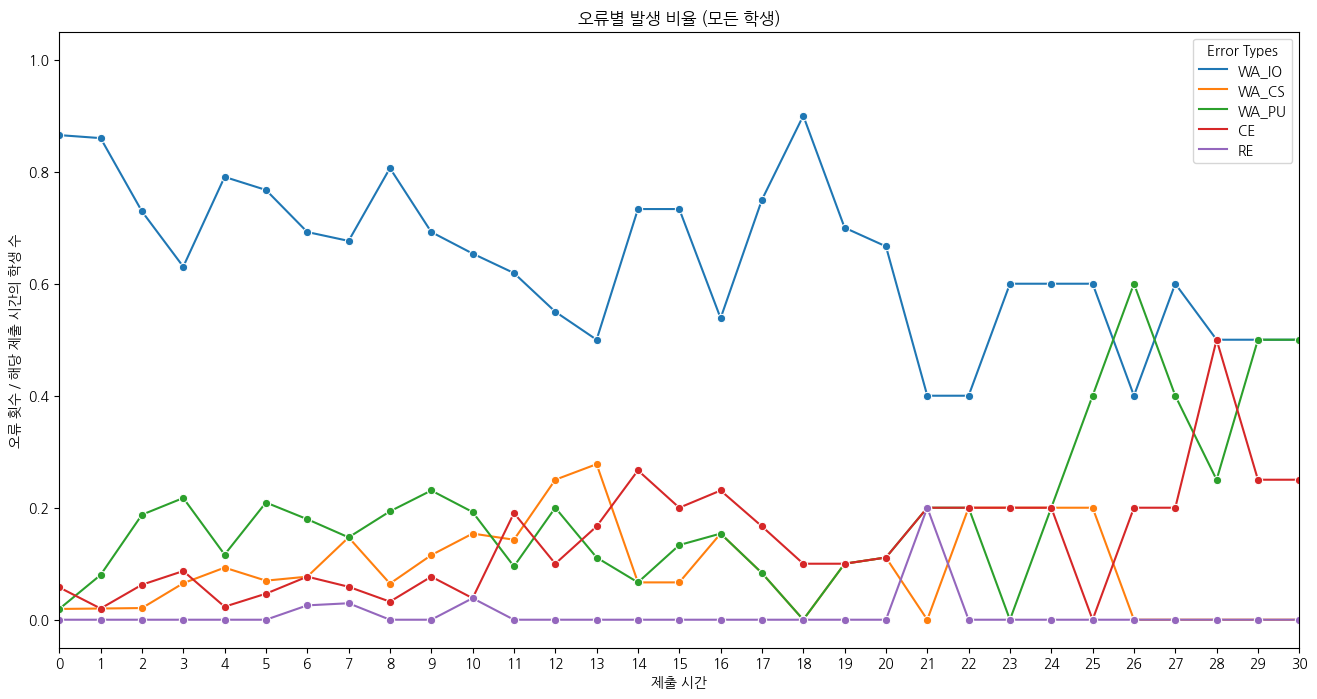

In [156]:
# 각 제출 시간에 제출한 학생 수 계산후 데이터프레임 재구성
error_by_time = data4.groupby('제출 시간').sum().reset_index()
num_students_by_time = data4.groupby('제출 시간')['학생명'].nunique().reset_index(name='num_students')
merged_by_time = pd.merge(error_by_time, num_students_by_time, on='제출 시간')
merged_by_time[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']] = merged_by_time[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].div(merged_by_time['num_students'], axis=0)

error_ratio = merged_by_time.melt(id_vars='제출 시간',
                                 value_vars=['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE'],
                                 var_name='Error Types',
                                 value_name='ratio')

# 시각화
plt.rcParams["font.family"] = "NanumGothic"
plt.figure(figsize=(16, 8))
sns.lineplot(data=error_ratio, x='제출 시간', y='ratio', hue='Error Types', marker='o')

plt.title("오류별 발생 비율 (모든 학생)")
plt.xlabel("제출 시간")
plt.ylabel("오류 횟수 / 해당 제출 시간의 학생 수")

plt.xlim(0, 30) # 최소 학생수>3
plt.xticks(range(0, 31))
plt.show()


<span style="font-size:20px;">**- 클러스터링을 통해 형성된 군집에서의 시간별 분석**</span>

<span style="font-size:16px;">**1. Cluster0의 제출시간별 오류 비율 (기초실력이 있다고 판단했던 그룹)**</span>

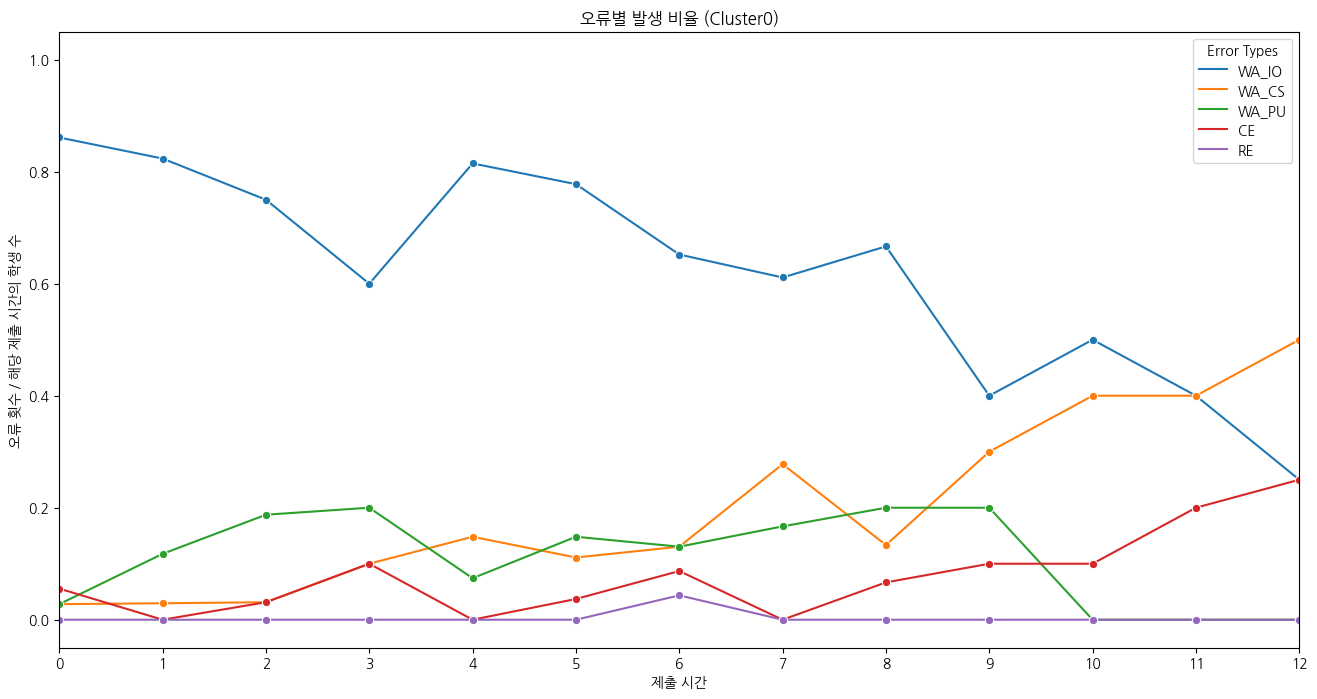

In [157]:
# 클러스터 0 학생들의 데이터만 선택
data4_cluster0 = data4[data4['학생명'].isin(cluster0_students)]

# 각 제출 시간에 제출한 학생 수 계산
num_students_by_time_cluster0 = data4_cluster0.groupby('제출 시간')['학생명'].nunique().reset_index(name='num_students')

# 클러스터 0의 학생들에 대해 각 오류 유형의 발생 횟수를 제출 시간별로 계산
error_by_time_cluster0 = data4_cluster0[['제출 시간', 'WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].groupby('제출 시간').sum().reset_index()
merged_by_time_cluster0 = pd.merge(error_by_time_cluster0, num_students_by_time_cluster0, on='제출 시간')

# 각 오류 유형의 발생 횟수를 해당 제출 시간에 제출한 학생 수로 나눠 오류 비율을 계산
merged_by_time_cluster0[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']] = merged_by_time_cluster0[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].div(merged_by_time_cluster0['num_students'], axis=0)

error_ratio_cluster0 = merged_by_time_cluster0.melt(id_vars='제출 시간',
                                                   value_vars=['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE'],
                                                   var_name='Error Types',
                                                   value_name='ratio')

# 시각화
plt.rcParams["font.family"] = "NanumGothic"
plt.figure(figsize=(16, 8))
sns.lineplot(data=error_ratio_cluster0, x='제출 시간', y='ratio', hue='Error Types', marker='o')

plt.title("오류별 발생 비율 (Cluster0)")
plt.xlabel("제출 시간")
plt.ylabel("오류 횟수 / 해당 제출 시간의 학생 수")

plt.xlim(0, 12) # 최소 학생수>3
plt.xticks(range(0, 13))
plt.show()


<span style="font-size:16px;">**2. Cluster1의 제출시간별 오류 비율 (기초실력이 부족하다고 판단했던 그룹)**</span>

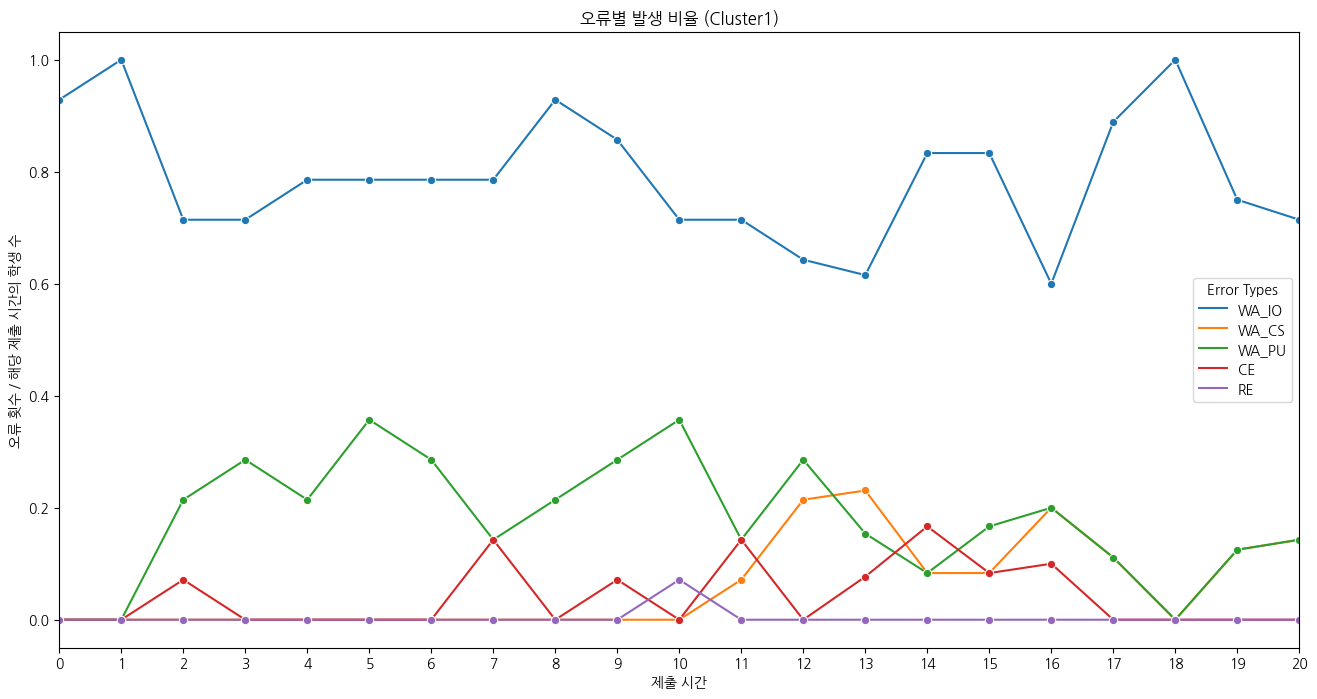

In [158]:
# 클러스터 1 학생들의 데이터만 선택
data4_cluster1 = data4[data4['학생명'].isin(cluster1_students)]

# 각 제출 시간에 제출한 학생 수 계산
num_students_by_time_cluster1 = data4_cluster1.groupby('제출 시간')['학생명'].nunique().reset_index(name='num_students')

# 클러스터 1의 학생들에 대해 각 오류 유형의 발생 횟수를 제출 시간별로 계산
error_by_time_cluster1 = data4_cluster1[['제출 시간', 'WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].groupby('제출 시간').sum().reset_index()
merged_by_time_cluster1 = pd.merge(error_by_time_cluster1, num_students_by_time_cluster1, on='제출 시간')

# 각 오류 유형의 발생 횟수를 해당 제출 시간에 제출한 학생 수로 나눠 오류 비율을 계산
merged_by_time_cluster1[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']] = merged_by_time_cluster1[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].div(merged_by_time_cluster1['num_students'], axis=0)

error_ratio_cluster1 = merged_by_time_cluster1.melt(id_vars='제출 시간',
                                                   value_vars=['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE'],
                                                   var_name='Error Types',
                                                   value_name='ratio')

# 시각화
plt.rcParams["font.family"] = "NanumGothic"
plt.figure(figsize=(16, 8))
sns.lineplot(data=error_ratio_cluster1, x='제출 시간', y='ratio', hue='Error Types', marker='o')

plt.title("오류별 발생 비율 (Cluster1)")
plt.xlabel("제출 시간")
plt.ylabel("오류 횟수 / 해당 제출 시간의 학생 수")

plt.xlim(0, 20) # 최소 학생수>3
plt.xticks(range(0, 21))
plt.show()


# 6. 클러스터링 결과의 정확성 검증

<span style="font-size:20px;">**- 코딩 실력이 미흡했던 그룹(cluster1)과 그렇지 않은 그룹(cluster0)에서의 정답률을 통해 검증**</span><br>
정답률 50%를 기준으로 했을 때, 50% 이상인 학생들은 주로 cluster0에, 50% 미만인 학생들은 주로 cluster1에 속했는지 확인

In [159]:
#에러가 나는경우 df1셀을 다시 실행시켜주세요
test_correct = df1
test_correct.drop(columns=['제출 시간', '문제 이름', '코드', '오류 분류'], inplace=True)
test_correct = test_correct.groupby('학생명').sum().reset_index()
test_correct['AC_RATE'] = test_correct['AC'] / (test_correct['AC'] + test_correct['WA_IO'] + test_correct['WA_CS'] + test_correct['WA_PU'] + test_correct['CE'] + test_correct['RE'])

In [160]:
test_data = test_correct
test_data['cluster_labels_filtered'] = filtered_data['cluster_labels_filtered']

# 클러스터 0의 정답률 계산
cluster0_data = test_data[test_data['cluster_labels_filtered'] == 0]
correct_cluster0 = cluster0_data[cluster0_data['AC_RATE'] >= 0.5]
accuracy_cluster0 = len(correct_cluster0) / len(cluster0_data)

# 클러스터 1의 정답률 계산
cluster1_data = test_data[test_data['cluster_labels_filtered'] == 1]
correct_cluster1 = cluster1_data[cluster1_data['AC_RATE'] < 0.5]
accuracy_cluster1 = len(correct_cluster1) / len(cluster1_data)

# 결과 출력
print(f"Cluster 0 정확도: {accuracy_cluster0 * 100:.2f}%") #학생의 정답률이 50% 이상이면 정확히 분류된 것
print(f"Cluster 1 정확도: {accuracy_cluster1 * 100:.2f}%") #학생의 정답률이 50% 미만이면 정확히 분류된 것

Cluster 0 정확도: 94.44%
Cluster 1 정확도: 85.71%


# 7. 학생별 오류 유형 / 세부 내용 / 개선방안 도출

<span style="font-size:20px;">**- 개별 학생들의 오류 유형별 누적 추이**</span>

In [213]:
from IPython.display import display
import pandas as pd

data2=df2

# 사용자로부터 학생명을 입력받음
student_name = input("학생명을 입력해주세요: ")

# 해당 학생의 데이터를 찾고, "제출 시간" 순으로 정렬
student_data = data2[data2["학생명"] == student_name]
sorted_student_data = student_data.sort_values(by="제출 시간")

# 정렬된 결과 출력
pd.set_option("display.max_rows", len(sorted_student_data))
display(sorted_student_data)

학생명을 입력해주세요: 허윤구


,학생명,제출 시간,문제 이름,코드,오류 분류,WA_IO,WA_CS,WA_PU,CE,RE
537,허윤구,2021-03-07 10:45:00,두정수바꾸어출력하기,#include<cstdio>\nint main()\n{\n int a;\n ...,0,1,0,0,0,0
538,허윤구,2021-03-07 10:47:00,두정수바꾸어출력하기,#include<cstdio>\nint main()\n{\n int a;\n ...,0,1,0,0,0,0
753,허윤구,2021-03-07 11:03:00,시간단위로변환하기,#include<cstdio>\nint main()\n{\n int a;\n ...,1,0,0,1,0,0
754,허윤구,2021-03-07 11:04:00,시간단위로변환하기,#include<cstdio>\nint main()\n{\n int a;\n ...,1,0,0,1,0,0
1403,허윤구,2021-03-07 11:06:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",2,1,0,0,0,0
1403,허윤구,2021-03-07 11:06:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",0,1,0,0,0,0
1407,허윤구,2021-03-07 11:07:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",0,1,0,0,0,0
1402,허윤구,2021-03-07 11:07:00,사칙연산,"#include <cstdio>\nint main()\n{\n int a, b...",0,1,0,0,0,0
1402,허윤구,2021-03-07 11:07:00,사칙연산,"#include <cstdio>\nint main()\n{\n int a, b...",2,1,0,0,0,0
1407,허윤구,2021-03-07 11:07:00,사칙연산,"#include<cstdio>\nint main()\n{\n int a, b;...",2,1,0,0,0,0


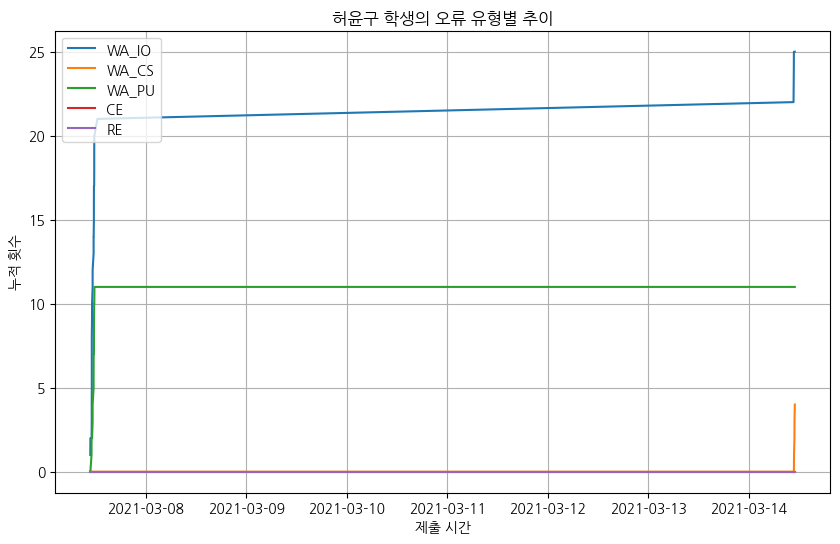

In [214]:
# 누적값 계산
sorted_student_data[['WA_IO_cum', 'WA_CS_cum', 'WA_PU_cum', 'CE_cum', 'RE_cum']] = sorted_student_data[['WA_IO', 'WA_CS', 'WA_PU', 'CE', 'RE']].cumsum()

# 제출 시간을 x축, 누적 값을 y축으로 설정하고 그래프를 출력
plt.rcParams["font.family"] = "NanumGothic"
plt.figure(figsize=(10, 6))
plt.plot(sorted_student_data['제출 시간'], sorted_student_data['WA_IO_cum'], label='WA_IO')
plt.plot(sorted_student_data['제출 시간'], sorted_student_data['WA_CS_cum'], label='WA_CS')
plt.plot(sorted_student_data['제출 시간'], sorted_student_data['WA_PU_cum'], label='WA_PU')
plt.plot(sorted_student_data['제출 시간'], sorted_student_data['CE_cum'], label='CE')
plt.plot(sorted_student_data['제출 시간'], sorted_student_data['RE_cum'], label='RE')

plt.xlabel('제출 시간')
plt.ylabel('누적 횟수')
plt.title(f'{student_name} 학생의 오류 유형별 추이')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


학생명을 입력하세요: 유재학


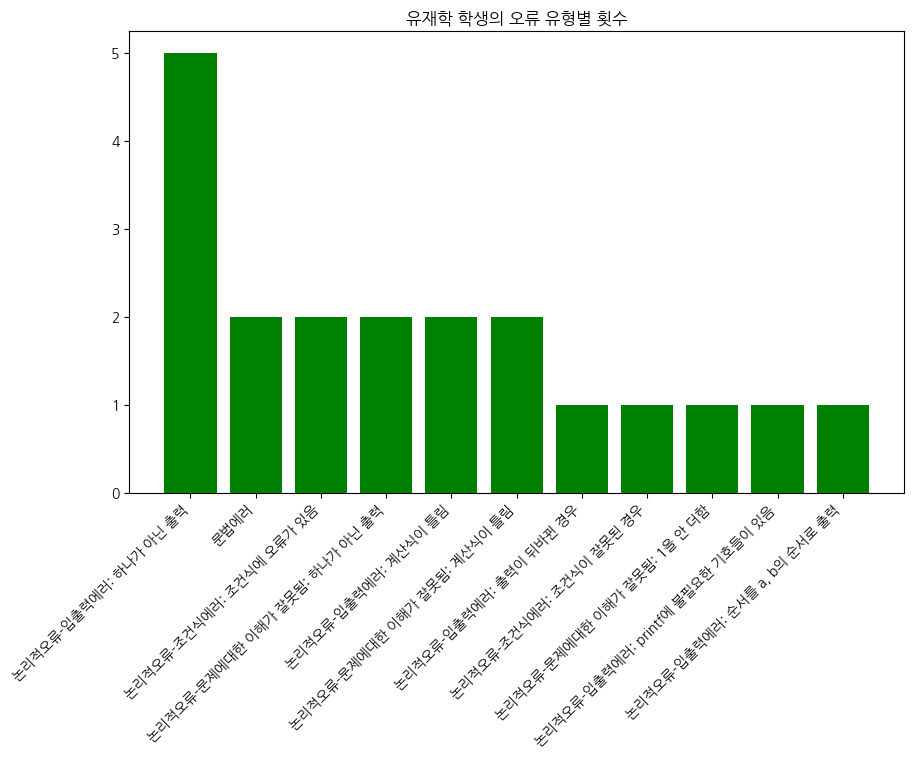



<유재학 학생의 오류 유형>

문법에러 x2
논리적오류-입출력에러: 출력이 뒤바뀐 경우
논리적오류-조건식에러: 조건식이 잘못된 경우
논리적오류-조건식에러: 조건식에 오류가 있음 x2
논리적오류-문제에대한 이해가 잘못됨: 1을 안 더함
논리적오류-입출력에러: 하나가 아닌 출력 x5
논리적오류-문제에대한 이해가 잘못됨: 하나가 아닌 출력 x2
논리적오류-입출력에러: 계산식이 틀림 x2
논리적오류-문제에대한 이해가 잘못됨: 계산식이 틀림 x2
논리적오류-입출력에러: printf에 불필요한 기호들이 있음
논리적오류-입출력에러: 순서를 a, b의 순서로 출력


<AI 피드백>

가장 자주 틀리는 유형은 다음과 같습니다:

1. 논리적 오류 - 조건식에러: 조건식이 잘못된 경우
2. 논리적 오류 - 문제에 대한 이해가 잘못됨: 1을 안 더함
3. 논리적 오류 - 입출력에러: 하나가 아닌 출력
4. 논리적 오류 - 계산식이 틀림
5. 논리적 오류 - 문제에 대한 이해가 잘못됨: 계산식이 틀림

이러한 유형의 오류가 가장 자주 발생하는 것으로 보입니다. 이러한 오류를 줄이기 위해서는 조건식과 계산식을 올바르게 작성하고, 문제에 대한 이해를 정확하게 하여 올바른 출력을 얻을 수 있도록 해야 합니다. 또한, printf 함수에 불필요한 기호들이 포함되지 않도록 주의해야 합니다. 순서를 a, b의 순서로 출력해야 할 경우에도 순서를 올바르게 지정해야 합니다.


In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import openai
from collections import Counter

data3=df2

# errors.xlsx : 각 문제별 "오류 분류"컬럼에 해당하는 숫자를 description으로 바꿔주는 문서
errors_data = pd.read_excel("errors.xlsx")

# 학생명 입력 받기
student_name = input("학생명을 입력하세요: ")

# 해당 학생의 최근 20개 샘플 찾기
student_data = data3[data3["학생명"] == student_name].sort_values(by="제출 시간", ascending=False).head(20)

# 각 문제별 오류 분류 번호에 따른 설명을 추가
error_strings = []
for index, row in student_data.iterrows():
    if row['WA_IO'] == 1:
        error_string = "논리적오류-입출력에러: "
        details = errors_data.loc[(errors_data["문제 이름"] == row["문제 이름"]) & (errors_data["오류 분류"] == row["오류 분류"]), "세부 설명"].values[0]
        error_string += details
        error_strings.append(error_string)
    if row['WA_CS'] == 1:
        error_string = "논리적오류-조건식에러: "
        details = errors_data.loc[(errors_data["문제 이름"] == row["문제 이름"]) & (errors_data["오류 분류"] == row["오류 분류"]), "세부 설명"].values[0]
        error_string += details
        error_strings.append(error_string)
    if row['WA_PU'] == 1:
        error_string = "논리적오류-문제에대한 이해가 잘못됨: "
        details = errors_data.loc[(errors_data["문제 이름"] == row["문제 이름"]) & (errors_data["오류 분류"] == row["오류 분류"]), "세부 설명"].values[0]
        error_string += details
        error_strings.append(error_string)
    if row['CE'] == 1:
        ce_errors = ["문법에러", "정의/선언에러", "형식/타입에러", "기타 컴파일 에러"]
        error_string = ce_errors[int(row["오류 분류"])]
        error_strings.append(error_string)
    if row['RE'] == 1:
        error_string = "런타임 에러"
        error_strings.append(error_string)

# 오류 유형별 횟수를 막대 그래프로 표시
keyword_counts = pd.Series(error_strings).value_counts()
plt.rcParams["font.family"] = "NanumGothic"
plt.figure(figsize=(10, 6))
plt.bar(keyword_counts.index, keyword_counts.values, color='green')
plt.title(f"{student_name} 학생의 오류 유형별 횟수")
plt.xticks(rotation=45, ha="right")
plt.show()

# Error_strings에 있는 키워드(오류 유형들) 출력
print(f"\n\n<{student_name} 학생의 오류 유형>\n")
counted_errors = Counter(error_strings)
for error, count in counted_errors.items():
    if count > 1:
        print(f"{error} x{count}")
    else:
        print(error)

# GPT API (Feedback을 위한 쿼리)
def feedback(query):

    # FTA API
    API_KEY = "API_KEY_HERE"
    openai.api_key = API_KEY

    model = "gpt-3.5-turbo"  

    messages = [
        {"role":"system", "content":"You are an assistant who analyzes code errors and suggests improvements."},
        {"role":"user","content": f"발생한 코드 에러 내용들입니다:\n{query}\n 가장 자주 틀리는 유형만 정리해서 말해주세요."}
    ]

    response = openai.ChatCompletion.create(
        temperature=0.5,
        model=model,
        messages = messages
    )

    answer = response['choices'][0]['message']['content']

    return answer

query = " ".join([f"- {error_string}" for error_string in error_strings])

suggestions = feedback(query)
print("\n\n<AI 피드백>\n")
print(suggestions)
